# Delay Tolerant Networks

### Description

In several instances, network communications can occur with relevant delays, as for extra-terrestial communications or for supervised monitoring networks. In such network deciding which node can communicate with which other node and when is extremely complicated issue (a np-completed scheduling problem).

### Assignments

1. Generate a series of patterns of transmissions on a network represented as a graph. In such graph the edges are weighted accordingly to the delay between transmittion and reception.
2. Implement euristic algorithms to lower the potential of the network, i.e. aiming at minimizing the distance of the communications from their final destination.
3. Find out the most efficient algorithm

### Contacts
Leonardo Badia <badia@dei.unipd.it>

# Introduction to Delay Tolerant Networks

Delay Tolerant Networking (DTN) is a relatively new area of research which 
is rapidly becoming the focus of considerable effort. DTN is an approach
to computer architecture that seeks to address the technical issues in 
heterogeneus networks that may lack continuos network connectivity. The
final aim of this developing study area is to tackle problems which the 
Internet is not able to face.  

There's a great variety among the different DTNs: they range from deep 
space networks to buses driving around mobile wireless hotspots in 
villages to provide Internet service to kiosks. 

The big difference from the regular Internet Protocol (IP) is that IP
assumes a seamless end-to-end data path instead DTNs are built to account
for errors and disconnections. Unlike IP, where heterogeneus networks are 
connected by assigning each node a common network-layer identifier (IP address),
a DTN uses "naming, layering, encapsulation and persistent storage".

The situations in which we use DTNs are pretty challenging:

* The throughput is generally low (we can think for instance about the acoustic in underwater modems) and may 
be highly asymmetric or in the worse scenario a return channel might not 
exist

* These networks are frequently disconnected, not only by faults but due
to motion for instance

* These systems frequently operate with a low duty cycle and the queuing 
time can be very large; with these conditions TCP would time out the session
instead UDP would lose all the packets.

We decided to use 2 different approaches in order to face to routing problem with DTNs. The first one is a greedy
algorithm while the second is an epidemic algorithm. 

Before going into the details of the two different algorithms there are some assumptions that need to be pointed out:
    
* We are working with infinite buffers 

* There are no errors in transmission

* There's a maximum distance between two satellites beyond which they can't communicate

* We keep the same size for every packet

* This is a centralized system, in the sense that Earth knows all the topology of the network


In [1]:
#used to import the utility functions
import sys
sys.path.insert(1, "utility_functions/")

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
import math
import pylab as pl
from matplotlib import collections  as mc
import mpl_toolkits.mplot3d.axes3d as p3
from network_utilities import generate_network, plot_network, disable_links, adjacency_matrix
from greedy_routing import greedy_routing, DTN_dijkstra, dijkstra_on_nodes, find_next_interval
from graphics import pkt_plot
from metrics import throughput, delay, deviations
import pandas as pd
from epidemics import add_packet, arrive_to_earth, check_link, epidemic
from tqdm import tqdm
np.random.seed(100)

################################################
n = 10                                         #
c = 3e8                                        #
T_tx = 10  # da regolare                       #
r_max = 60e9  # Marte                          #
tau_max = 200                                  #
delta_time = 10                                #
################################################

In [2]:
nodes = generate_network(n,r_max)
A = adjacency_matrix(nodes,tau_max)
sorted_nodes = np.argsort(A[0,:])     #sorting based on distance from Earth
A = A[sorted_nodes,:][:,sorted_nodes]
if(True):   #TEST
    print(nodes.shape)
    print(A.shape)
    print("sorted_nodes: {}".format(sorted_nodes))

(10, 3)
(10, 10)
sorted_nodes: [0 4 5 8 1 2 9 6 7 3]


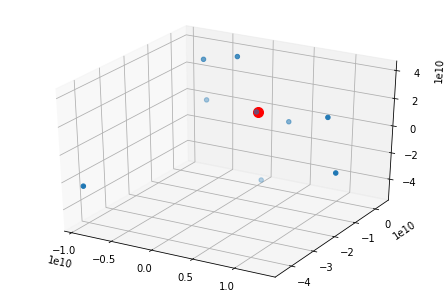

In [3]:
plot_network(nodes)

In [4]:
### TEST disable links
### sorted nodes = [0 4 5 8 1 2 9 3 6 7]

if(False):   #TEST
    At = disable_links(A,100,1,mode="unstable")

    for i in range(20):
        B = np.copy(At[:,:,i*5])
        B[B>tau_max] = 0
        plt.spy(B)
        plt.show()

# Greedy Routing

In every network where data is generated from a node and needs to be delivered to a different one, may it be the postal network or the internet, it is necessary to find out the route that the data should follow in order to reach its destination.

This is usually done by a routing algorithm, in the internet the most widely used ones are the Dijikstra and the Bellman-Ford algorithms, these two are used in order to find the shortest path from the source to the destination according to some metric that could be the number of hops, the end to end delay etc.

<!-- The code below is html and I used it because it gives much more freedom for
controlling images-->
<figure>
    <img src="figures/routing.svg" width=500/>
    <div style="text-align: center;"> 
        <i>
            Path obtained by applying routing between the two nodes
        </i>
    </div>
</figure>

Classical routing algorithms do not work on DTNs (Delay Tolerant Networks) because they were thought for systems where links are supposed to fail very rarely and where the end to end delay is relatively small.

In the internet the chance of a link failing is low and even if it does the end to end delay is small, so in case a packet is lost because of link failure sending the packet again is not too expensive.
In DTNs this is not true because:

* The propagation time is very high, expecially if we are considering satellite communication

* The chance of link failure is very high.

On top of that it is not even possible to find the best routing algorithm for networks, this is because if also the traffic generated by other nodes is taken into consideration the problem becomes NP.
By analyzing the state of the art in DTN it is possible to see that the best results are mostly obtained by using greedy algorithms, i. e. algorithms that take a decision by choosing the best choice at each iteration without considering long term planning.

In order to perform routing in this work by hypothesis we have full knowledge of the topology and evolution of the network. This is not a very strict requirement as it might happen in real life, for example for satellite networks, where usually link failure is caused by the interference of a celestial body, the requirement can be easily satisfied.

The first of the two implemented algorithms chooses the best next hop for the packet by using a slightly modified version of the dijkstra algorithm that computes the best path from the source to the destination at a specific point in time.

It is also necessary to take collisions into account, so if sending one packet causes one the sender needs to wait until it is sure that no collision will occur. After the idle time waited in order to avoid collisions the optimal path needs to be recomputed because, due to topology changes, it might not be optimal anymore.

## Modified Dijkstra

In general the Dijkstra algorithm is used to find the best path between two nodes in weighted graphs with positive weights.

<figure>
    <img src="figures/dijkstra.gif" width=300/>
    <div style="text-align: center;"> 
        <i>
            Dijkstra algorithm in action
        </i>
    </div>
</figure>

Usually the algorithm is run on graphs that have fixed topology, unfortunately for DNTs this is not the case, hence a link that was active when the packet was sent might not be active when the packet reaches its destination.

This has to be taken into account because a link failing while a message is being sent through the link will result in packet loss.

An implementation of the Dijkstra algorithm for DTNs that solved this problem was proposed in [1].
With this approach the weight of a node is considered equal to $t_p + t_{tr} + t_w$ where $t_p$ is the propagation time, $t_{tr}$ is the transmission time and $t_w$ is the total time that the sender needs to wait before sending because of link failures.

The pseudo code for the algorithm is:
```
Input = G=(E, V), s, T, w(e,t)
Q = V
L[s]=0
L[v]=inf for every v != s
while Q != {} do
    u = u in Q that minimizes L[u]
    Q = Q - u
    for each edge e in E between u and another vertex v do
        if L[v] > L[u] + w(e, T + L[u]) then
            L[v] = L[u] + w(e, T + L[u])
        end if
    end for
end while
```
Where G is the graph representing the network, s is the starting node, T is the starting time, w(e,t) is the weight of edge e at time t.
The only difference from the standard algorithm is that in the standard case w(e,t) is constant in t, meaning that by correctly computing the function w(e,t) the algorithm will be able to find shortest paths also in the case of changing topology.


In [5]:
packets = np.random.randint(1, n, (10000, 2))
packets[:,1] = 0

ttr = T_tx
At = disable_links(A, 500000, delta_time ,mode="unstable")
if True:
    packets = greedy_routing(At, packets, ttr, delta_time, with_tqdm =True)
    packet_distribution = [0 for i in range(n)]
    for packet in packets:
        for node in packet.route:
            if node != packet.destination:
                packet_distribution[node] += 1

100%|██████████| 10000/10000 [00:18<00:00, 527.19it/s]


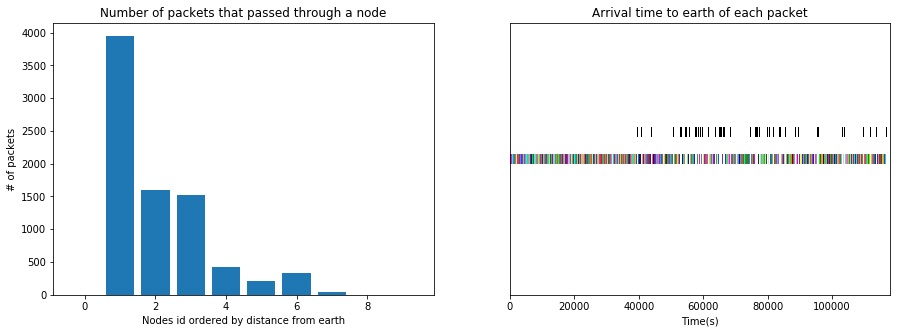

In [6]:
if True:
    _, axs = plt.subplots(1, 2, figsize = (15, 5))
    axs[0].bar(np.arange(n), packet_distribution)
    axs[0].set_title("Number of packets that passed through a node")
    axs[0].set_xlabel("Nodes id ordered by distance from earth")
    axs[0].set_ylabel("# of packets")
    pkt_plot(packets, ttr, axs[1]) 

# Interesting observations

The two previous plots enables us to visualize some interesting properties we achieve with greedy routing. 

* The first histogram shows us the number of packets which have passed through a particular node. Given that 
the ordering of the nodes follows the distance from the Earth we immediately notice an intuitive fact that is: 
    the closer a node is to the destination the more packets will pass through it. This reassures us about the 
fact that the greedy algorithm is working properly and so each node is trying to send its packets to nodes
that are closer to Earth.

* With the second plot instead we visualize how efficient we are. Here we are plotting the arrival of the packets 
to destination; the different colors represent the various sources from which the packets have departed. 
The key observation here is that we have basically no idle times since Earth is always receiving packets, this
means that our algorithm is very efficient


100%|██████████| 10/10 [03:33<00:00, 21.34s/it]


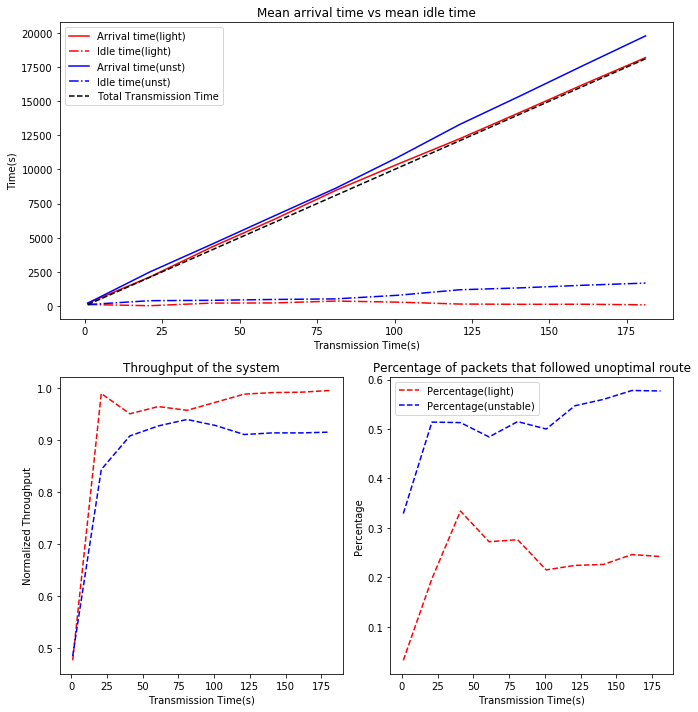

In [7]:
fig = plt.figure(figsize=(10, 10))

#generating the axes as wanted
gs = fig.add_gridspec(2, 2)
axs = []
axs.append(fig.add_subplot(gs[0, :]))
axs.append(fig.add_subplot(gs[1, 0]))
axs.append(fig.add_subplot(gs[1, 1]))

packets = np.random.randint(1, n, (100, 2))
packets[:,1] = 0

if True:
    for mode in ["light", "unstable"]:
        
        color = ["blue", "red"]
        color = color[mode == "light"]
        
        ttrs = range(1, 200, 20)
        
        max_rand = 10
        
        outputs = np.zeros((len(ttrs), max_rand))
        deviation_arr = np.zeros((len(ttrs), max_rand))

        for rand_iter in tqdm(range(max_rand)):

            nodes = generate_network(n,r_max)
            A = adjacency_matrix(nodes,tau_max)
            At = disable_links(A,500000, delta_time, mode=mode)

            for ttr_ind in range(len(ttrs)):

                results = greedy_routing(At, packets, ttrs[ttr_ind], delta_time)
                arrival_times = np.array([packet.arrival_times[-1] for packet in results])
                outputs[ttr_ind, rand_iter] = np.max(arrival_times)
                deviation_arr[ttr_ind, rand_iter] = deviations(A, results)

        arrival_times = np.mean(outputs, axis = 1)


        axs[0].plot(ttrs, arrival_times, linestyle="-", c = color)
        axs[0].plot(ttrs, arrival_times - packets.shape[0] * np.array(ttrs), linestyle="-.", c=color)
        
        axs[1].plot(ttrs, throughput(packets.shape[0], arrival_times)*np.array(ttrs), linestyle="--", c = color)

        axs[2].plot(ttrs, np.mean(deviation_arr, axis = 1), linestyle="--", c = color)

    axs[0].plot(ttrs, packets.shape[0] * np.array(ttrs), linestyle = "--", c="black")
    axs[0].set_ylabel("Time(s)")
    axs[0].set_xlabel("Transmission Time(s)")
    axs[0].set_title("Mean arrival time vs mean idle time")

    axs[0].legend([
        "Arrival time(light)", 
        "Idle time(light)",
        "Arrival time(unst)",
        "Idle time(unst)",
        "Total Transmission Time",
    ])

    axs[1].set_title("Throughput of the system")
    axs[1].set_ylabel("Normalized Throughput")
    axs[1].set_xlabel("Transmission Time(s)")


    axs[2].set_title("Percentage of packets that followed unoptimal route")
    axs[2].set_ylabel("Percentage")
    axs[2].set_xlabel("Transmission Time(s)")
    axs[2].legend([
        "Percentage(light)",
        "Percentage(unstable)"
    ])
    plt.tight_layout()

# An insight on the plots

With the first plot we are visualizing the arrival time, the idle time and the total transmission time as 
a function of the transmission time.

What we get is that the idle time remains almost equal to zero even if we increase the transmission time a 
lot. The total transmission time instead increases linearly whereas the arrival time is simply the sum of the
idle time and the total transmission time.

With the second plot we want to point out the dependency of the throughput on the Transmission Time; the throughput 
of the system increases really quickly in the first 50 seconds of time and then it reaches a plateau where the throughput
is greater than 0.9.

With the third plot instead we are highlighting the percentage of packets that followed unoptimal route as a function
of the transmission time. What we can observe is something very intuitive: the bigger the transmission time, the 
higher the percentage will be.

100%|██████████| 10/10 [04:15<00:00, 25.57s/it]


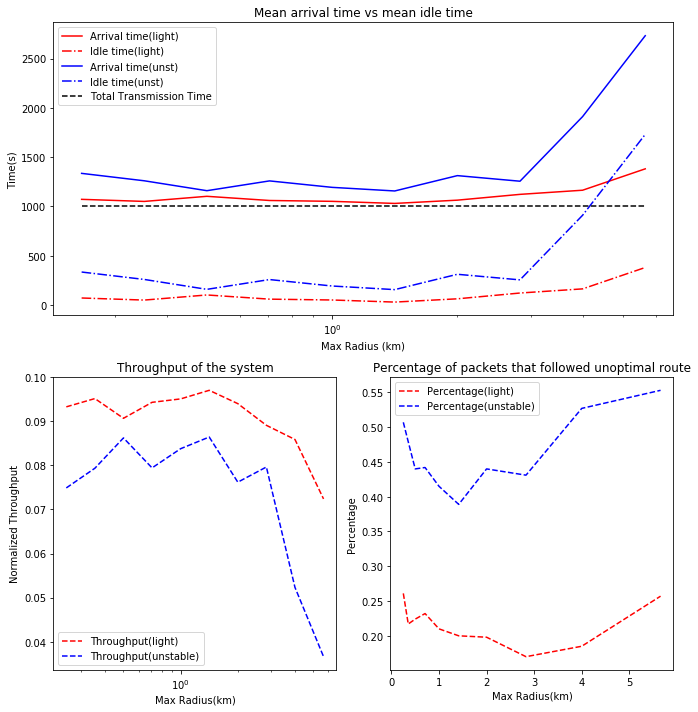

In [8]:
ttr = T_tx
fig = plt.figure(figsize=(10, 10))

#generating the axes as wanted
gs = fig.add_gridspec(2, 2)
axs = []
axs.append(fig.add_subplot(gs[0, :]))
axs.append(fig.add_subplot(gs[1, 0]))
axs.append(fig.add_subplot(gs[1, 1]))


if True:
    for mode in ["light", "unstable"]:
    
        color = ["blue", "red"]
        color = color[mode == "light"]
    
        r_maxes = [2**((i-4)/2) for i in range(10)]
        outputs = np.zeros((len(r_maxes), max_rand))
        deviation_arr = np.zeros((len(r_maxes), max_rand))

        for rand_iter in tqdm(range(max_rand)):

            nodes = generate_network(n, r_max)
            A = adjacency_matrix(nodes, tau_max)
            At = disable_links(A,200000, delta_time, mode=mode)

            for i in range(len(r_maxes)):
                #keeping the same configuration but rescaling the transmission times
                results = greedy_routing(At*r_maxes[i], packets, ttr, delta_time)
                arrival_times = np.array([packet.arrival_times[-1] for packet in results])
                outputs[i, rand_iter] = np.max(arrival_times)
                deviation_arr[i, rand_iter] = deviations(A*r_maxes[i], results)

        arrival_times = np.mean(outputs, axis = 1)

        axs[0].semilogx(r_maxes, arrival_times, linestyle="-", c = color)
        axs[0].semilogx(r_maxes, arrival_times - packets.shape[0] * ttr, linestyle="-.", c = color)

        axs[1].semilogx(r_maxes, throughput(packets.shape[0], arrival_times), linestyle="--", c = color)

        axs[2].plot(r_maxes, np.mean(deviation_arr, axis = 1), linestyle="--", c = color)

    axs[0].semilogx(r_maxes, np.ones(len(r_maxes))*packets.shape[0] * ttr, linestyle="--", c="black")
    axs[0].set_ylabel("Time(s)")
    axs[0].set_xlabel("Max Radius (km)")
    axs[0].set_title("Mean arrival time vs mean idle time")
    axs[0].legend([
        "Arrival time(light)", 
        "Idle time(light)",
        "Arrival time(unst)",
        "Idle time(unst)",
        "Total Transmission Time"
    ])

    axs[1].set_title("Throughput of the system")
    axs[1].set_ylabel("Normalized Throughput")
    axs[1].set_xlabel("Max Radius(km)")
    axs[1].legend([
        "Throughput(light)", 
        "Throughput(unstable)",
    ])

    axs[2].set_title("Percentage of packets that followed unoptimal route")
    axs[2].set_ylabel("Percentage")
    axs[2].set_xlabel("Max Radius(km)")
    axs[2].legend([
        "Percentage(light)",
        "Percentage(unstable)"
    ])
    plt.tight_layout()    



100%|██████████| 10/10 [05:11<00:00, 31.20s/it]


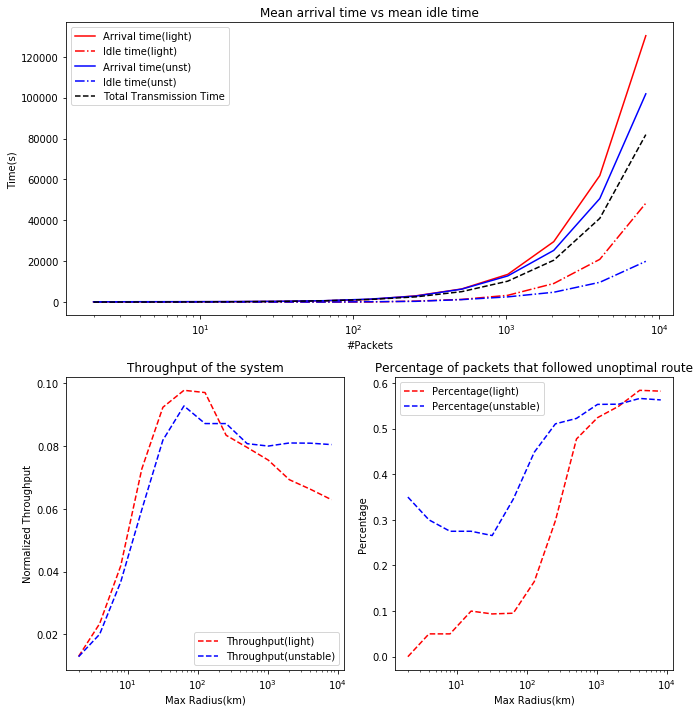

In [9]:
#%matplotlib inline
fig = plt.figure(figsize=(10, 10))

#generating the axes as wanted
gs = fig.add_gridspec(2, 2)
axs = []
axs.append(fig.add_subplot(gs[0, :]))
axs.append(fig.add_subplot(gs[1, 0]))
axs.append(fig.add_subplot(gs[1, 1]))

if True:
    for mode in ["light", "unstable"]:

        color = ["blue", "red"]
        color = color[mode == "light"]
        
        packet_numbers = [2**i for i in range(1,14)]
        outputs = np.zeros((len(packet_numbers), max_rand))
        deviation_arr = np.zeros((len(packet_numbers), max_rand))

        for rand_iter in tqdm(range(max_rand)):

            nodes = generate_network(n,r_max)
            A = adjacency_matrix(nodes,tau_max)
            At = disable_links(A,200000, delta_time, mode=mode)
            for i in range(len(packet_numbers)):
                packets = np.random.randint(1, n, (packet_numbers[i], 2))
                packets[:,1] = 0
                results = greedy_routing(At, packets, ttr, delta_time)
                arrival_times = np.array([packet.arrival_times[-1] for packet in results])
                outputs[i, rand_iter] = np.max(arrival_times)
                deviation_arr[i, rand_iter] = deviations(A, results)

        arrival_times = np.mean(outputs, axis = 1)

        axs[0].semilogx(packet_numbers, arrival_times, linestyle="-", c = color)
        axs[0].semilogx(packet_numbers, arrival_times - np.array(packet_numbers) * ttr, linestyle="-.", c=color)
        
        axs[1].semilogx(
            packet_numbers, 
            throughput(np.array(packet_numbers), arrival_times), 
            linestyle="--",
            c=color
        )

        axs[2].semilogx(packet_numbers, np.mean(deviation_arr, axis = 1), linestyle="--", c=color)

    axs[0].semilogx(packet_numbers, np.array(packet_numbers) * ttr, linestyle = "--", c="black")
    axs[0].set_ylabel("Time(s)")
    axs[0].set_xlabel("#Packets")
    axs[0].set_title("Mean arrival time vs mean idle time")
    axs[0].legend([
        "Arrival time(light)", 
        "Idle time(light)",
        "Arrival time(unst)",
        "Idle time(unst)",
        "Total Transmission Time"
    ])


    axs[1].set_title("Throughput of the system")
    axs[1].set_ylabel("Normalized Throughput")
    axs[1].set_xlabel("Max Radius(km)")
    axs[1].legend([
        "Throughput(light)", 
        "Throughput(unstable)",
    ])

    axs[2].set_title("Percentage of packets that followed unoptimal route")
    axs[2].set_ylabel("Percentage")
    axs[2].set_xlabel("Max Radius(km)")
    axs[2].legend([
        "Percentage(light)",
        "Percentage(unstable)"
    ])

    plt.tight_layout()

## Epidemic Algorithm
One of the most important problems in the DTN is the fact that the topology of network changes a lot over time. In same case, it is not possible to predict these network changes. For exemple in our case study, some celestial bodies could suddenly pass between the earth and our sattelites causing the link to fail and we cannot know if and when the link will become active again.<br> 
The epidemic algorithm suggests an approach that we can use to solve these types of problems,because it does not provide a complete and previous knowledge of the network topology. The algorithm works like an epidemic; if it is not possible send packets to earth, each node spreads the packets to all nearby nodes. So this procedure creates many copies of the same packet, in fact pure Epidemic routing has usually a high message delivery ratio. We can see below the main phases of the algorithm.<br>

   * 1) If the link is up the packets are sent from the node to the earth, if the link is down the packets are send to all nearby nodes that they can reach(the topology of network is full-connected, but it is possible that same links are temporarily interrupte)<br><br>
   
   * 2) This procedure is repeated for all nodes over time, until all the packets have arrived to earth. But if a node has already sent a copy of the packets to its neighbor, it hasen't to send it back.<br><br>
   
   * 3) It is possible that the packet is discarded. This happens when: the packet is send but during the propagation time the link breaks or when the packet arrives but there are same collition on the reciver because other packets arrive in the same moment.<br><br>
   
Using Epidemic algorithm, unless a node always remains isolated, we are sure that all packets arrive to earth. The problem is that many copies of the same packet can create a congestion in the network and an increase of total energy consumption for data transmission.
In this algorithm we assume to know the toplogy of network, namaly if the links are active or not, only in the current moment in which we are. We have not information about the future, so we can not route efficiently the packets, like happens in the algorithms above.


In [10]:
transmission_time = T_tx
slot_time = 10
packets = np.random.randint(1, n, (250, 2))
At = disable_links(A, 100000, slot_time, mode="unstable")
packet_arrive, packet_time, vulnerable = epidemic(At, transmission_time, slot_time, packets)
#the set is a data structure that removes all duplicates
print('packet_arrive', len(set(packet_arrive)))
print('packet_arrive_dupl', len(packet_arrive))
print("vulnerable times: ", vulnerable)


packet_arrive 250
packet_arrive_dupl 464
vulnerable times:  [5238.24189688 3350.         4420.         3780.         3493.24349139
 3365.92553734 4023.59835009 4141.15908196 3520.         4715.57882551]


In [11]:
data = pd.DataFrame(packet_time)
data.iloc[0:15,:]

,0,1,2,3,4,5,6,7,8
0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,29.117610,0.000000,0.000000
1,3047.864518,3610.561153,1356.746889,1317.188217,0.0,0.000000,1437.651534,3359.792997,1573.644426
2,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1169.117610,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.0,144.643547,0.000000,0.000000,0.000000
4,0.000000,108.241897,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
5,1727.864518,3796.823909,3466.746889,3350.000000,0.0,0.000000,1267.651534,3464.515053,3634.463563
6,1718.121556,3359.816569,3353.786703,1478.169571,0.0,0.000000,3358.494206,3436.522547,1412.663071
7,0.000000,128.241897,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
8,3243.203039,3128.058466,3359.156667,3359.792997,0.0,0.000000,1257.611816,3351.800491,3172.663071
9,3347.864518,3358.582012,1376.746889,1327.188217,0.0,0.000000,3358.533925,3359.792997,3358.494206


### An insight on the plots

With the first plot we are visualizing the arrival time and the total transmission time as a function of the number of packets in two different network cofiguration.
What we get is that the arrival time increases exponentially in both configuration.<br>
With the second plot we want to point the dependency of the packet delivery ratio on the number of packets, in order to understand how change the number of copies packets in the newtwork.<br>
In the plot below, we have repeated the same figure but we have halved the maximum radius of transmission and incresed number of nodes. In this case, as we can expected, packet fraction reaches lower values, becuase same nodes can not send the packets to earth directly so the number of copies packets obviously will be increse.<br>
With second figure we are visualizing the arrival time as a function of transmission time and the packet delivery ratio using the same configuration as above. We can see that, in case we halve the maximum radius of transmission, the arrival time increses because the network is more congensted.


100%|██████████| 10/10 [00:34<00:00,  3.41s/it]


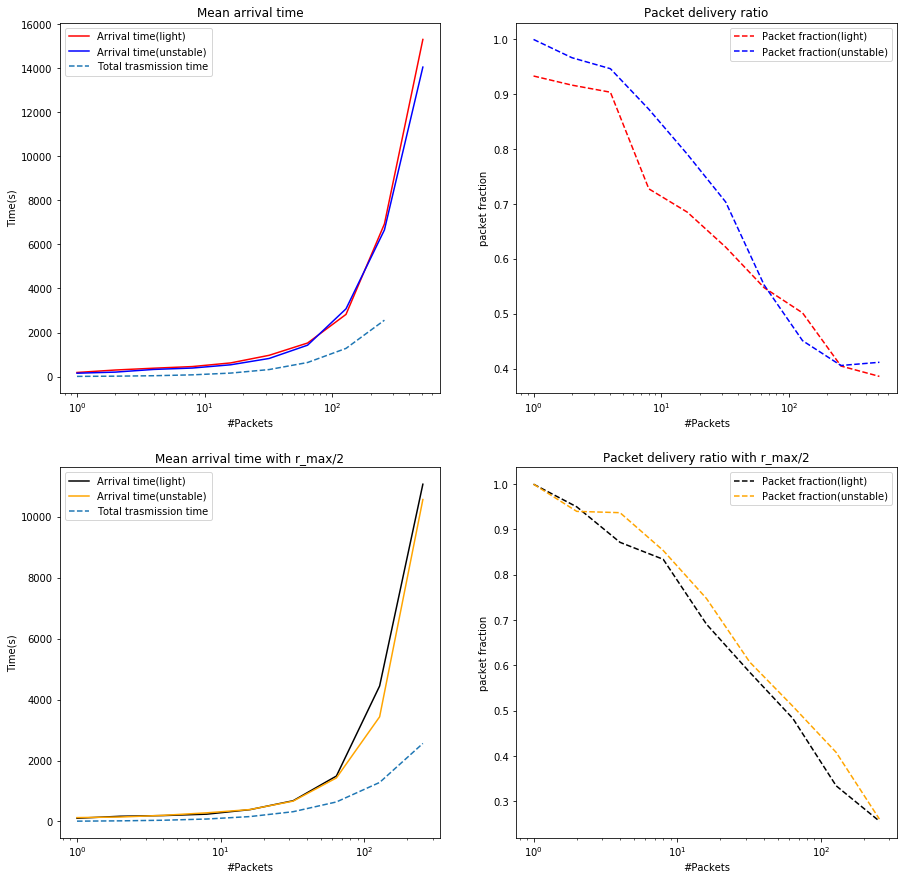

In [12]:
#generate figure
fig = plt.figure(figsize=(15, 15))
    
gs = fig.add_gridspec(2, 2)
axs = []
axs.append(fig.add_subplot(gs[0, 0]))
axs.append(fig.add_subplot(gs[0, 1]))
axs.append(fig.add_subplot(gs[1, 0]))
axs.append(fig.add_subplot(gs[1, 1]))
#seeing how the system behaves as number of packets increases
max_rand = 10

for mode in ["light", "unstable"]:

    color = ["blue", "red"]
    color = color[mode == "light"]
    #number packet that we want to send to earth
    packet_numbers = [2**i for i in range(10)]
    arrival_times = np.zeros((len(packet_numbers), max_rand))
    packet_fraction = np.zeros((len(packet_numbers), max_rand))
    
    for sample in tqdm(range(max_rand)):
        
        nodes = generate_network(n, r_max)
        A = adjacency_matrix(nodes, tau_max)
        At = disable_links(A, 100000, slot_time, mode = "unstable")
    
        for i in range(len(packet_numbers)):

            packets = np.random.randint(1, n, (packet_numbers[i], 2))
            packet_arrive, _, vulnerable = epidemic(At, transmission_time, slot_time, packets)
            arrival_times[i, sample] = vulnerable[0] + transmission_time
            packet_fraction[i, sample] = len(set(packet_arrive))/len(packet_arrive)

    axs[0].semilogx(packet_numbers, np.mean(arrival_times, axis = 1), c = color)
    axs[1].semilogx(packet_numbers, np.mean(packet_fraction, axis = 1), c = color, linestyle="--")

for mode in ["light", "unstable"]:

    color = ["orange", "black"]
    color = color[mode == "light"]
    #number packet that we want to send to earth
    packet_numbers = [2**i for i in range(9)]
    arrival_times = np.zeros((len(packet_numbers), max_rand))
    packet_fraction = np.zeros((len(packet_numbers), max_rand))
    
    for sample in tqdm(range(max_rand)):
        nodes = generate_network(n*2, r_max/2)
        A = adjacency_matrix(nodes, tau_max)
        At = disable_links(A, 100000, slot_time, mode = "unstable")
    
        for i in range(len(packet_numbers)):

            packets = np.random.randint(1, n*2, (packet_numbers[i], 2))
            packet_arrive, _, vulnerable = epidemic(At, transmission_time, slot_time, packets)
            arrival_times[i, sample] = vulnerable[0] + transmission_time
            packet_fraction[i, sample] = len(set(packet_arrive))/len(packet_arrive)

    axs[2].semilogx(packet_numbers, np.mean(arrival_times, axis = 1), c = color)
    axs[3].semilogx(packet_numbers, np.mean(packet_fraction, axis = 1), c = color, linestyle="--")
    
    
axs[0].semilogx(packet_numbers, np.array(packet_numbers)*transmission_time, linestyle="--")
axs[0].set_ylabel("Time(s)")
axs[0].set_xlabel("#Packets")
axs[0].set_title("Mean arrival time")
axs[0].legend([
    "Arrival time(light)",
    "Arrival time(unstable)",
    "Total trasmission time"
])

axs[1].set_ylabel("packet fraction")
axs[1].set_xlabel("#Packets")
axs[1].set_title("Packet delivery ratio")
axs[1].legend([
    "Packet fraction(light)",
    "Packet fraction(unstable)"
])

axs[2].semilogx(packet_numbers, np.array(packet_numbers)*transmission_time, linestyle="--")
axs[2].set_ylabel("Time(s)")
axs[2].set_xlabel("#Packets")
axs[2].set_title("Mean arrival time with r_max/2")
axs[2].legend([
    "Arrival time(light)",
    "Arrival time(unstable)",
    "Total trasmission time"
])

axs[3].set_ylabel("packet fraction")
axs[3].set_xlabel("#Packets")
axs[3].set_title("Packet delivery ratio with r_max/2")
axs[3].legend([
    "Packet fraction(light)",
    "Packet fraction(unstable)"
])


In [ ]:
#generate figure
fig = plt.figure(figsize=(15, 15))
   
gs = fig.add_gridspec(2, 2)
axs = []
axs.append(fig.add_subplot(gs[0, 0]))
axs.append(fig.add_subplot(gs[0, 1]))
axs.append(fig.add_subplot(gs[1, 0]))
axs.append(fig.add_subplot(gs[1, 1]))

#seeing how the system behaves as the transmission time increases
max_rand = 10
packet_numbers = 100
for mode in ["light", "unstable"]:

    color = ["blue", "red"]
    color = color[mode == "light"]
    
    trasm_time = np.arange(1, 200, 20)
    arrival_times = np.zeros((len(trasm_time), max_rand))
    packet_fraction = np.zeros((len(trasm_time), max_rand))
    
    for sample in tqdm(range(max_rand)):
        
        nodes = generate_network(n, r_max)
        A = adjacency_matrix(nodes, tau_max)
        At = disable_links(A, 100000, slot_time, mode = "unstable")
    
        for i in range(len(trasm_time)):

            packets = np.random.randint(1, n, (packet_numbers, 2))
            packet_arrive, _, vulnerable = epidemic(At, trasm_time[i], slot_time, packets)
            arrival_times[i, sample] = vulnerable[0] + trasm_time[i]
            packet_fraction[i, sample] = len(set(packet_arrive))/len(packet_arrive)
               
    axs[0].semilogx(trasm_time, np.mean(arrival_times, axis = 1), c = color)
    axs[0].set_ylabel("Time(s)")
    axs[0].set_xlabel("Transmission time")
    axs[0].set_title("Mean arrival time")
    axs[0].legend([
    "Arrival time(light)",
    "Arrival time(unstable)",
    ])
    
    axs[1].semilogx(trasm_time, np.mean(packet_fraction, axis = 1), c = color, linestyle = "--")
    axs[1].set_ylabel("packet fraction")
    axs[1].set_xlabel("Transmission time")
    axs[1].set_title("Packet delivery ratio")
    axs[1].legend([
    "Packet fraction(light)",
    "Packet fraction(unstable)"
    ])

for mode in ["light", "unstable"]:

    color = ["orange", "black"]
    color = color[mode == "light"]
    
    trasm_time = np.arange(1, 200, 20)
    arrival_times = np.zeros((len(trasm_time), max_rand))
    packet_fraction = np.zeros((len(trasm_time), max_rand))
    
    for sample in tqdm(range(max_rand)):
        
        nodes = generate_network(n*2, r_max/2)
        A = adjacency_matrix(nodes, tau_max)
        At = disable_links(A, 100000, slot_time, mode = "unstable")
    
        for i in range(len(trasm_time)):

            packets = np.random.randint(1, n*2, (packet_numbers, 2))
            packet_arrive, _, vulnerable = epidemic(At, trasm_time[i], slot_time, packets)
            arrival_times[i, sample] = vulnerable[0] + trasm_time[i]
            packet_fraction[i, sample] = len(set(packet_arrive))/len(packet_arrive)
               
    axs[2].semilogx(trasm_time, np.mean(arrival_times, axis = 1), c = color)
    axs[2].set_ylabel("Time(s)")
    axs[2].set_xlabel("Transmission time")
    axs[2].set_title("Mean arrival time with r_max/2")
    axs[2].legend([
    "Arrival time(light)",
    "Arrival time(unstable)",
    ])
   

    axs[3].semilogx(trasm_time, np.mean(packet_fraction, axis = 1), c = color, linestyle = "--")
    axs[3].set_ylabel("packet fraction")
    axs[3].set_xlabel("Transmission time")
    axs[3].set_title("Packet delivery ratio with r_max/2")
    axs[3].legend([
    "Packet fraction(light)",
    "Packet fraction(unstable)"
    ])


 10%|█         | 1/10 [00:03<00:27,  3.05s/it]

In [ ]:
## ANIMATION 1

#enable first line to make the animation work
#WARNING: all other figures will be affected until you restart the kernel

#%matplotlib notebook 

coord = np.copy(nodes)
polar = generate_network(n,r_max,polar=True)

def update_graph(num):

    theta = polar[:,1]
    phi = polar[:,2]
    
    old_r = np.linalg.norm(coord,axis=1)
    
    coord[:,0] += - c*np.cos(theta)*np.sin(phi)
    coord[:,1] += - c*np.sin(theta)*np.sin(phi)
    coord[:,2] += - c*np.cos(phi)
    
    new_r = np.linalg.norm(coord,axis=1)
    
    not_done = new_r < old_r  #this happens after a packet reach Earth

    #coord = coord * not_done.reshape((n,-1))  #sets coordinates of a pkt to 0 if it already reached Earth

    for i in range(n):    # ISSUE: previous line doesn't work, this "for" cycle is a substitute
        if not not_done[i]:
            coord[i,0] = coord[i,1] = coord[i,2] = 0
            
    graph._offsets3d = (coord[:,0],coord[:,1],coord[:,2])
    title.set_text("time={}".format(num))


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
title = ax.set_title('Pkts')

graph = ax.scatter(coord[:,0],coord[:,1],coord[:,2])
ax.scatter(0,0,0,color="red",s=60)   #Earth

ani = animation.FuncAnimation(fig, update_graph, 
                               interval=50, blit=False)

plt.show()

In [ ]:
## ANIMATION 2

#enable first line to make the animation work
#WARNING: all other figures will be affected until you restart the kernel

%matplotlib notebook 

#returns a list of active links
def get_links(A):
    n = A.shape[0]
    return [np.array([nodes[i],nodes[j]]).T for i in range(n) for j in range(i+1) if A[i,j]!=np.inf]

#checks if a link is active 
def check_active(link, link_list):
    for x in link_list:
        if np.array_equal(x, link):
            return True
    return False

At = disable_links(A,5000,1,mode="unstable")  #test

n_updates = At.shape[2]
links = get_links(A)
active_links = [get_links(At[:,:,t]) for t in range(n_updates)]

def update_lines(num, dataLines, lines) :

    title.set_text("time={}".format(num))
    
    for line, data in zip(lines, dataLines) :
        # NOTE: there is no .set_data() for 3 dim data...
        line.set_data(data[0:2, :])
        line.set_3d_properties(data[2, :])
        line.set_color("black")
        if not check_active(data, active_links[num]):
              line.set_color("red")
    return lines

# Attaching 3D axis to the figure
fig = plt.figure()
ax = p3.Axes3D(fig)

data = links
lines = [ax.plot(dat[0, :], dat[1, :], dat[2, :],alpha=0.5)[0] for dat in links]

if True:   #autoscale off
    # Setting the axes properties
    ax.set_xlim3d([-4e10, 4e10])
    ax.set_xlabel('X')

    ax.set_ylim3d([-4e10, 4e10])
    ax.set_ylabel('Y')

    ax.set_zlim3d([-4e10,4e10])
    ax.set_zlabel('Z')

title = ax.set_title('Links')

# Creating the Animation object
line_ani = animation.FuncAnimation(fig, update_lines, n_updates, fargs=(data, lines),
                              interval=5, blit=False)

plt.show()

# Bibliography

[1] Jain, Sushant, Kevin Fall, and Rabin Patra. "Routing in a delay tolerant network." Proceedings of the 2004 conference on Applications, technologies, architectures, and protocols for computer communications. 2004.<br>
[2] Evan P.C. Jone, Paul A.S. War. "Routing Strategies for Delay-Tolerant Networks."